In [2]:
from statsbombpy import sb
import pandas as pd
import numpy as np

In [3]:
#All events sorted for barca home games and possession 
events = sb.competition_events(
    country="Germany",
    division= "1. Bundesliga",
    season="2023/2024",
    gender="male"
)

df = events[events["possession_team"]=="Bayer Leverkusen"]
df = df[df["team"]=="Bayer Leverkusen"]


/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarni

In [ ]:
position_dict = {}
for id in events.match_id.unique():
    #find the data form match with current id
    match_subset = events.loc[events['match_id'] == id]

    #identify the starting 11
    starting_11 = match_subset.loc[(match_subset['type'] == 'Starting XI') & (match_subset['team'] == 'Bayer Leverkusen'), 'tactics'].to_list()[0]
    starting_11_dict = {}

    
    #make a dictionary for positions of players
    for member in starting_11['lineup']:
        player_id = member['player']['id']
        position_name = member['position']['name']
        starting_11_dict[player_id] = position_name
    
    position_dict[id] = {0 : starting_11_dict}

    match_subset = match_subset.loc[(match_subset['team'] == 'Bayer Leverkusen') & (match_subset['type'].isin(['Substitution', 'Tactical Shift']))]

    #sort the values like when we did the passing sequences
    match_subset = match_subset.sort_values(['period','timestamp'], ascending=[True, True])

    for index, row in match_subset.iterrows():
        #If substitution, we update the dictionary to include player
        if row['type'] == 'Substitution':
            match_dict = position_dict[id]
            latest_lineup = match_dict[list(match_dict.keys())[-1]]
            latest_lineup[row['substitution_replacement_id']] = row['position']
            position_dict[id][row['possession']] = latest_lineup
          
        #In case of a tactical shift, create a new position_dict
        if row['type'] == 'Tactical Shift':
            new_formation = row['tactics']
            lineup = {}
            for member in new_formation['lineup']:
                player_id = member['player']['id']
                position_name = member['position']['name']
                lineup[player_id] = position_name
            position_dict[id][row['possession']] = lineup

/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_45456/2924918892.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_subset['pass_recipient_position'] = np.nan
/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_45456/2924918892.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_subset['pass_recipient_position'] = np.nan
/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_45456/2924918892.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [5]:
#filter threshold for Xg:
df_xg = df[~df['shot_statsbomb_xg'].between(0, 0.05)]

In [6]:
#Events sorted in a specific order so each passing sequence is correctly sorted
sequences_sorted = df_xg.sort_values(['match_id', 'period','timestamp'], ascending=[True, True, True])

In [7]:
#make new ids because right now there is ids from 1 to x for each match but it repeats from 1 and up in every match so each possession id points to different matches 
# - i just put the possession id after match_id in the newly created id
sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)
sequences_sorted['possession_id'] = sequences_sorted['possession_id'].astype(int)

/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_59635/955078220.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)


In [8]:
#get the ids of sequences which contain a shot (contain an xg value)
shot_sequences = sequences_sorted[sequences_sorted["shot_statsbomb_xg"].notna()]
shot_sequences_ids = shot_sequences["possession_id"].unique()

In [9]:
#filter for possession sequences which end with a shot
sequences_filtered = sequences_sorted[sequences_sorted['possession_id'].isin(shot_sequences_ids)]

In [10]:
#fill all rows with an xg for the corresponding sequence - right now there are many missing values in "shot_statsbomb_xg"
sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))

/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_59635/2851514471.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_59635/2851514471.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_59635/2851514471.py:2: Se

In [11]:
#find ids of those possessions that result in a goal
goal_posession_index = sequences_filtered.loc[sequences_filtered["shot_outcome"]=="Goal", "possession_id"]

In [12]:
#now we dont need the shot event rows any more so remove them
sequences_filtered = sequences_filtered[sequences_filtered["type"]!="Shot"]

Nu begynder jeg at arbejde på, at lave spillerne til nodes

In [13]:
#filter the df to only include row with an id the of a pass recipient and we subset the columns
player_final_sequences =  sequences_filtered[sequences_filtered["pass_recipient"].notna()][["match_id", "possession", "position", "pass_recipient_id", "possession_id", "xg"]]

In [14]:
#remove sequences with few passes if wanted
index_counts = player_final_sequences['possession_id'].value_counts()
player_final_sequences = player_final_sequences[player_final_sequences['possession_id'].isin(index_counts[index_counts > 5].index)]

In [15]:
#get all the unique possession ids for iteration
possession_index = player_final_sequences["possession_id"].unique()

In [ ]:
player_final_sequences['pass_recipient_position'] = np.nan

for index, row in player_final_sequences.iterrows():
    recipient = row['pass_recipient_id']

    lineups = position_dict[row['match_id']]

    i = 0
    keys = list(lineups.keys())

    #Find out the current line up at the time of the event
    while i <= len(keys)-2 and row['possession'] > keys[i+1]:
        i += 1
    
    lineup = lineups[keys[i]]

    player_final_sequences.at[index, 'pass_recipient_position']  = lineup[recipient]


/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_59635/3799606067.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Right Center Back' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  player_final_sequences.at[index, 'pass_recipient_position']  = lineup[recipient]


In [19]:
import networkx as nx

#iterate over possession ids and each row and append edges to a list for each graph and append that graph to a graphs dictionary (directed graph created with "nx.DiGraph(edges)")
#xg added as an attribute for each graph
graphs_dict = {}
for j in possession_index:
    edges = []
    for i in player_final_sequences.index:
        if j == player_final_sequences["possession_id"][i]:
            edges.append((player_final_sequences["position"][i], player_final_sequences["pass_recipient_position"][i]))
            if j not in graphs_dict:
                graphs_dict[j] = {"xg": player_final_sequences["xg"][i], "graph": None}
            else:
                graphs_dict[j]["xg"] = player_final_sequences["xg"][i]
                
    graph = nx.DiGraph(edges)
    graphs_dict[j]["graph"] = graph

graph_list = [value["graph"] for value in graphs_dict.values()]

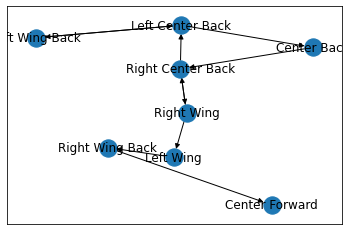

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

game_pos = 389505258

# Draw the graph using the positions
nx.draw_networkx(graphs_dict[game_pos]["graph"])

# Show the plot
plt.show()
